In [1]:
# Core
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Vision
from torchvision import datasets, transforms
import timm

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# Progress bar
from tqdm import tqdm


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
DATA_DIR = "/kaggle/input/brain-tumor-mri-dataset"

TEST_DIR  = DATA_DIR + "/test"
TRAIN_DIR = DATA_DIR + "/train"


print("Train exists:", os.path.exists(TRAIN_DIR))
print("Test exists :", os.path.exists(TEST_DIR))
print("Train folders:", os.listdir(TRAIN_DIR))


Train exists: True
Test exists : True
Train folders: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


In [5]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

class_names = train_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)
print("Train images:", len(train_dataset))
print("Test images :", len(test_dataset))


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4
Train images: 5723
Test images : 1430


In [6]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


glioma: 1297
meningioma: 1420
notumor: 1600
pituitary: 1406


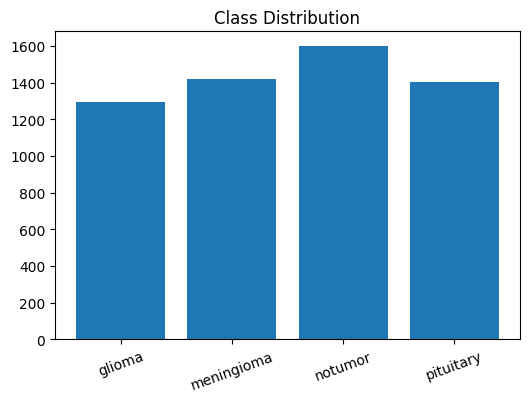

In [7]:
train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)

for idx, count in class_counts.items():
    print(f"{class_names[idx]}: {count}")

plt.figure(figsize=(6,4))
plt.bar([class_names[i] for i in class_counts.keys()], class_counts.values())
plt.title("Class Distribution")
plt.xticks(rotation=20)
plt.show()


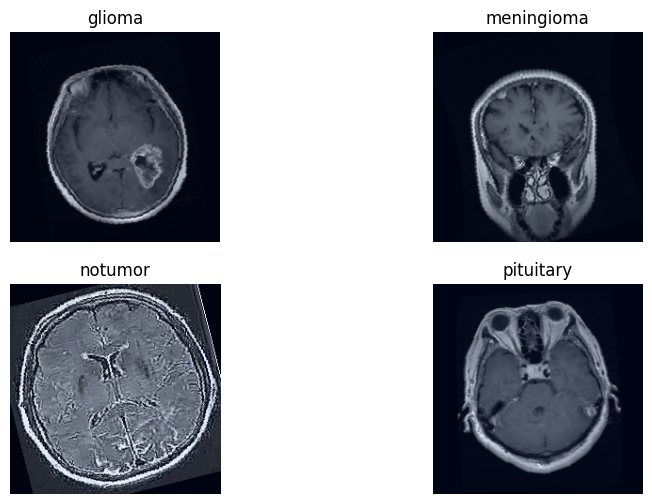

In [8]:
plt.figure(figsize=(10,6))

shown = set()
i = 0

while len(shown) < num_classes:
    img, label = train_dataset[i]
    if label not in shown:
        shown.add(label)
        plt.subplot(2,2,len(shown))
        img = img.permute(1,2,0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")
    i += 1

plt.show()


In [9]:
model = timm.create_model("efficientnet_b0", pretrained=True)

in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [10]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


In [11]:
optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-4
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=3,
    factor=0.3
)


In [18]:
from collections import Counter
import torch

# Extract labels from training dataset
train_labels = [label for _, label in train_dataset]

# Count samples per class
class_counts = Counter(train_labels)
print("Class counts:", class_counts)

# Compute weights
total_samples = len(train_labels)
num_classes = len(class_names)

class_weights = []
for i in range(num_classes):
    class_weights.append(total_samples / class_counts[i])

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:", class_weights)


Class counts: Counter({2: 1600, 1: 1420, 3: 1406, 0: 1297})
Class weights: tensor([4.4125, 4.0303, 3.5769, 4.0704], device='cuda:0')


In [19]:
# Re-define criterion safely
criterion = nn.CrossEntropyLoss(weight=class_weights)

print("Criterion defined successfully")


Criterion defined successfully


In [20]:
def train_one_epoch(model, loader):
    model.train()
    running_loss, correct, total = 0, 0, 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss=loss.item(), acc=correct/total)

    return running_loss/len(loader), correct/total


In [21]:
def validate_one_epoch(model, loader):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            pbar.set_postfix(loss=loss.item(), acc=correct/total)

    return running_loss/len(loader), correct/total, y_true, y_pred


In [22]:
EPOCHS = 15
best_acc = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, y_true, y_pred = validate_one_epoch(model, test_loader)

    scheduler.step(val_loss)

    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_stage1.pth")
        print("✔ Best Stage-1 Model Saved")



Epoch 1/15


Train Acc: 0.4763 | Val Acc: 0.7399
✔ Best Stage-1 Model Saved

Epoch 2/15


Train Acc: 0.7664 | Val Acc: 0.8336
✔ Best Stage-1 Model Saved

Epoch 3/15


Train Acc: 0.8307 | Val Acc: 0.8776
✔ Best Stage-1 Model Saved

Epoch 4/15


Train Acc: 0.8515 | Val Acc: 0.8860
✔ Best Stage-1 Model Saved

Epoch 5/15


Train Acc: 0.8717 | Val Acc: 0.8986
✔ Best Stage-1 Model Saved

Epoch 6/15


Train Acc: 0.8822 | Val Acc: 0.9014
✔ Best Stage-1 Model Saved

Epoch 7/15


Train Acc: 0.8910 | Val Acc: 0.9042
✔ Best Stage-1 Model Saved

Epoch 8/15


Train Acc: 0.9063 | Val Acc: 0.9154
✔ Best Stage-1 Model Saved

Epoch 9/15


Train Acc: 0.9163 | Val Acc: 0.9287
✔ Best Stage-1 Model Saved

Epoch 10/15


Train Acc: 0.9226 | Val Acc: 0.9322
✔ Best Stage-1 Model Saved

Epoch 11/15


Train Acc: 0.9217 | Val Acc: 0.9420
✔ Best Stage-1 Model Saved

Epoch 12/15


Train Acc: 0.9350 | Val Acc: 0.9483
✔ Best Stage-1 Model Saved

Epoch 13/15


Train Acc: 0.9355 | Val Acc: 0.9490
✔ Best Stage-1 Model Saved

Epoch 14/15


Train Acc: 0.9478 | Val Acc: 0.9531
✔ Best Stage-1 Model Saved

Epoch 15/15


Train Acc: 0.9542 | Val Acc: 0.9587
✔ Best Stage-1 Model Saved


In [23]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

for block in model.blocks[-2:]:
    for param in block.parameters():
        param.requires_grad = True

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5
)


In [24]:
FINE_EPOCHS = 10

for epoch in range(FINE_EPOCHS):
    print(f"\nFine-Tune Epoch {epoch+1}/{FINE_EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, y_true, y_pred = validate_one_epoch(model, test_loader)

    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


torch.save({
    "model_state_dict": model.state_dict(),
    "class_names": class_names
}, "brain_tumor_efficientnet_b0_final.pth")

print("✔ FINAL MODEL SAVED")




Fine-Tune Epoch 1/10


Train Acc: 0.9542 | Val Acc: 0.9573

Fine-Tune Epoch 2/10


Train Acc: 0.9574 | Val Acc: 0.9601

Fine-Tune Epoch 3/10


Train Acc: 0.9610 | Val Acc: 0.9629

Fine-Tune Epoch 4/10


Train Acc: 0.9612 | Val Acc: 0.9678

Fine-Tune Epoch 5/10


Train Acc: 0.9645 | Val Acc: 0.9643

Fine-Tune Epoch 6/10


Train Acc: 0.9689 | Val Acc: 0.9699

Fine-Tune Epoch 7/10


Train Acc: 0.9722 | Val Acc: 0.9734

Fine-Tune Epoch 8/10


Train Acc: 0.9748 | Val Acc: 0.9713

Fine-Tune Epoch 9/10


Train Acc: 0.9748 | Val Acc: 0.9804

Fine-Tune Epoch 10/10


Train Acc: 0.9750 | Val Acc: 0.9762
✔ FINAL MODEL SAVED


Classification Report:

              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       324
  meningioma       0.97      0.94      0.96       355
     notumor       0.98      1.00      0.99       400
   pituitary       0.98      0.99      0.98       351

    accuracy                           0.98      1430
   macro avg       0.98      0.98      0.98      1430
weighted avg       0.98      0.98      0.98      1430



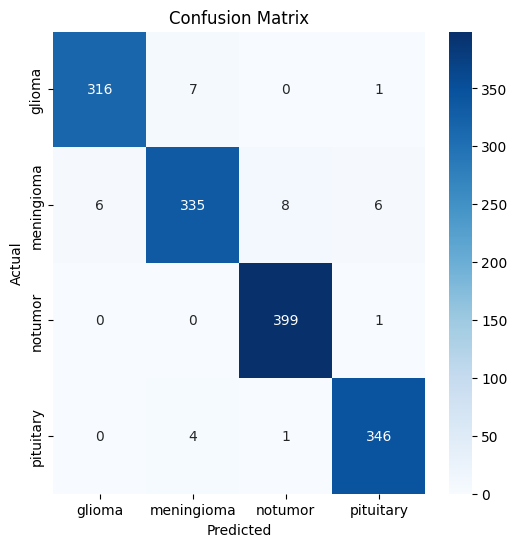

In [25]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
